<a href="https://colab.research.google.com/github/jejjohnson/xrpatcher/blob/add-concat-notebook/notebooks/xrpatcher_concat_torch_dataloading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xrpatcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import xrpatcher
import torch
import itertools

class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, patcher: xrpatcher.XRDAPatcher, item_postpro=None):
        self.patcher = patcher
        self.postpro = item_postpro

    def __getitem__(self, idx):
        item = self.patcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.patcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.patcher)


class XrConcatDataset(torch.utils.data.ConcatDataset):
    def __init__(self, *dses: XrTorchDataset):
        super().__init__(dses)

    def reconstruct_from_batches(self, batches, weight=None):
        items_iter = itertools.chain(*batches)
        rec_das = []
        for ds in self.datasets:
            ds_items = list(itertools.islice(items_iter, len(ds)))
            rec_das.append(ds.patcher.reconstruct(ds_items, weight=weight))

        return rec_das



In [94]:
import xarray as xr
ds = xr.tutorial.load_dataset('air_temperature')
ds = ds.sortby('lat')

domains = [
    dict(lat=slice(15, 35), lon=slice(200, 220)),
    dict(lat=slice(55, 75), lon=slice(300, 320)),
]


patching_kw = dict(patches=dict(time=720), strides=dict(time=200))

patcher1 = xrpatcher.XRDAPatcher(ds.air, domain_limits=domains[0], **patching_kw)
patcher2 = xrpatcher.XRDAPatcher(ds.air, domain_limits=domains[1], **patching_kw)


torch_ds1 = XrTorchDataset(patcher1)
torch_ds2 = XrTorchDataset(patcher2)

torch_ds = XrConcatDataset(torch_ds1, torch_ds2)

print(f'{patcher1=}')
print()

print(f'{patcher2=}')
print()

print(f'{len(torch_ds1)=}')
print(f'{len(torch_ds1)=}')
print()

print(f'{len(torch_ds)=}')




patcher1=XArray Patcher
DataArray Size: OrderedDict([('time', 2920), ('lat', 9), ('lon', 9)])
Patches:        OrderedDict([('time', 720), ('lat', 9), ('lon', 9)])
Strides:        OrderedDict([('time', 200), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('time', 12), ('lat', 1), ('lon', 1)])

patcher2=XArray Patcher
DataArray Size: OrderedDict([('time', 2920), ('lat', 9), ('lon', 9)])
Patches:        OrderedDict([('time', 720), ('lat', 9), ('lon', 9)])
Strides:        OrderedDict([('time', 200), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('time', 12), ('lat', 1), ('lon', 1)])

len(torch_ds1)=12
len(torch_ds1)=12

len(torch_ds)=24


In [78]:
dl = torch.utils.data.DataLoader(torch_ds, batch_size=4)
rec_da1, rec_da2 = torch_ds.reconstruct_from_batches(list(dl))

100%|██████████| 12/12 [00:00<00:00, 54.38it/s]


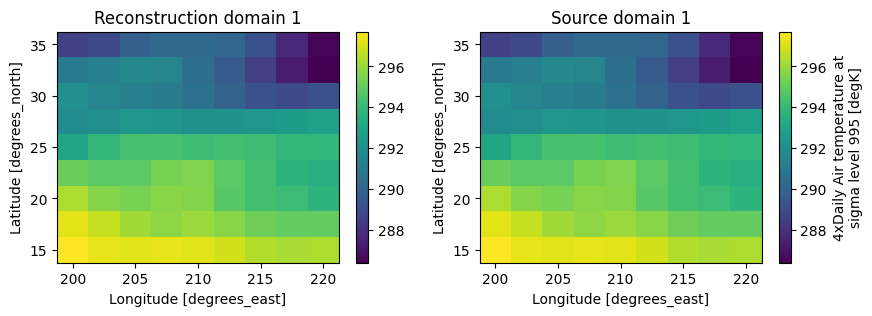

Text(0.5, 1.0, 'Source domain 2')

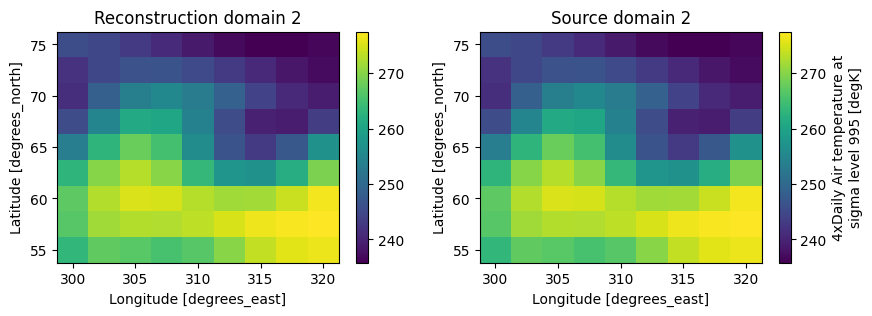

In [92]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
rec_da1.isel(time=10).plot(ax=ax1)
ax1.set_title('Reconstruction domain 1')
patcher1.da.isel(time=10).plot(ax=ax2)
ax2.set_title('Source domain 1')

plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
rec_da2.isel(time=10).plot(ax=ax1)
ax1.set_title('Reconstruction domain 2')
patcher2.da.isel(time=10).plot(ax=ax2)
ax2.set_title('Source domain 2')


In [96]:

rec_da = xr.full_like(ds.air, float('nan'))
rec_da.loc[rec_da1.coords] = rec_da1
rec_da.loc[rec_da2.coords] = rec_da2

Text(0.5, 1.0, 'Source data')

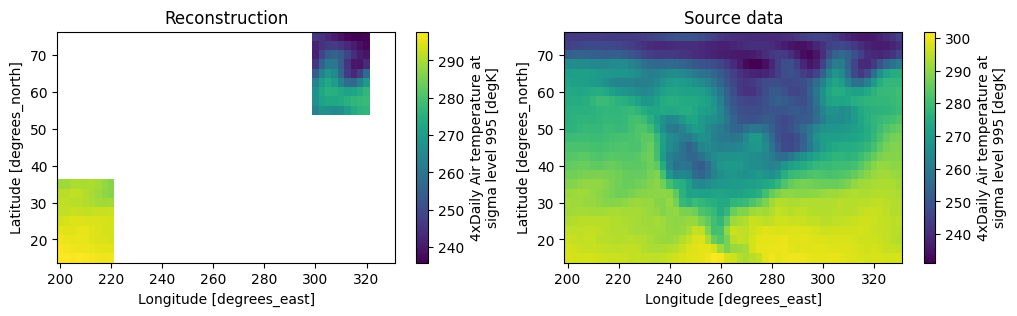

In [101]:
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
rec_da.isel(time=10).plot(ax=ax1)
ax1.set_title('Reconstruction')
ds.air.isel(time=10).plot(ax=ax2)
ax2.set_title('Source data')